# <center>*Keypad eavesdropping based on mobile phone sensors*

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### <center>*Load the data and store them in a dict.*

In [2]:
ML_PATH = './SensorData/'

def load_data(csv_name, path=ML_PATH):
    csv_path = os.path.join(ML_PATH, csv_name)
    return pd.read_csv(csv_path)

data = {'key{}'.format(i): load_data('{}.csv'.format(i)) for i in range(1, 10)}

### <center>*Find the empty rows' label.*

In [3]:
# fill the NAN with '999'
for i in range(1, 10):
    data['key{}'.format(i)].y = data['key{}'.format(i)].y.fillna(999)

# get the row-label of the NAN, and store it in a dict.
seperate = {'sep{}'.format(i): data['key{}'.format(i)][(data['key{}'.format(i)].y == 999)].index.tolist() for i in range(1, 10)}

# insert a -1 in the first place of every key.
for i in range(1, 10):
    seperate['sep{}'.format(i)].insert(0, -1)

### <center>*Get the features and label.*

In [4]:
# get the features and labels

def get_features(key, sep, X):
    for i in range(98):
        f = data[key].iloc[seperate[sep][i] + 1: seperate[sep][i+1], 2:].describe().to_numpy().reshape(1, -1)
        X = np.r_[X, f]
    return X

def get_label(key, sep, y):
    for i in range(98):
        l = data[key].iloc[seperate[sep][i] + 1, 0].reshape(-1, 1)
        y = np.r_[y, l]
    return y

In [5]:
X = np.zeros([1, 24])
y = np.zeros([1, 1])

for i in range(1, 10):
    X = get_features('key{}'.format(i), 'sep{}'.format(i), X)
X = np.delete(X, 0, axis=0)
X = np.delete(X, [0, 1, 2], axis=1)

for i in range(1, 10):
    y = get_label('key{}'.format(i), 'sep{}'.format(i), y)
y = np.delete(y, 0, axis=0)

### <center>*Distribute the train set and test set.*

In [6]:
from sklearn.model_selection import train_test_split

# get train set and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### <center>*Define a function to visualize the result(using t-sne algorithm)*

In [7]:
import sklearn
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects
import matplotlib
import seaborn as sns    # We import seaborn to make nice plots.

# Random state.
RS = 2020 

sns.set_style('darkgrid') 
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
rc={"lines.linewidth": 2.5})

def plot_scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))
    
    # We create a scatter plot.
    f = plt.figure(figsize=(10, 6))
    ax = plt.subplot(aspect='equal') 
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit. 
    txts = []
    for i in range(10):
    # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])
        txts.append(txt)
    return f, ax, sc, txts

## <center>*1. Multi-classification*

+ ### *Train a Multi-classification model.*

In [8]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf = clf.fit(X_train, y_train.ravel())
print('The score of test set is: ' + str(clf.score(X_test, y_test.ravel())))

The score of test set is: 0.879245283018868


+ ### *Evaluate the result.*

In [9]:
from sklearn.metrics import classification_report   # This package is a evaluation report.

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

         1.0       0.82      0.88      0.85        32
         2.0       0.81      0.96      0.88        23
         3.0       0.89      0.97      0.93        33
         4.0       0.89      0.71      0.79        34
         5.0       0.92      0.82      0.87        28
         6.0       0.84      0.93      0.88        28
         7.0       0.86      0.96      0.91        25
         8.0       0.93      0.84      0.88        31
         9.0       0.97      0.90      0.93        31

    accuracy                           0.88       265
   macro avg       0.88      0.88      0.88       265
weighted avg       0.88      0.88      0.88       265



+ ### *Visualize the result.*

c:\users\warriors\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\warriors\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
posx and posy should be finite values
posx and posy should be finite values


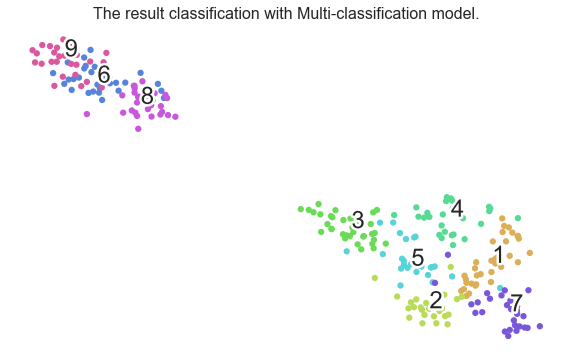

In [10]:
X_m = np.vstack([X_test[clf.predict(X_test) == i] for i in range(10)])
y_m = np.hstack([clf.predict(X_test)[clf.predict(X_test) == i] for i in range(10)])
digits_proj_m = TSNE(random_state=RS, perplexity=50).fit_transform(X_m)

plot_scatter(digits_proj_m, y_m)
plt.title('The result classification with Multi-classification model.', size=16)
plt.show()

## <center>*2. SVM*

+ ### *Train a SVM model.*

In [11]:
from sklearn import svm

# Complete SVM using the train set.
svc = svm.LinearSVC(C=85, loss='squared_hinge', max_iter=10000000)
svc = svc.fit(X_train, y_train.ravel())
print("The score of test set is: " + str(svc.score(X_test, y_test.ravel())))

The score of test set is: 0.939622641509434


+ ### *Evaluate the result.*

In [12]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

         1.0       1.00      0.91      0.95        32
         2.0       1.00      0.96      0.98        23
         3.0       0.91      0.97      0.94        33
         4.0       0.89      0.91      0.90        34
         5.0       0.87      0.93      0.90        28
         6.0       0.96      0.93      0.95        28
         7.0       0.93      1.00      0.96        25
         8.0       0.94      0.94      0.94        31
         9.0       1.00      0.94      0.97        31

    accuracy                           0.94       265
   macro avg       0.94      0.94      0.94       265
weighted avg       0.94      0.94      0.94       265



+ ### *Visualize the result.*

c:\users\warriors\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\warriors\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
posx and posy should be finite values
posx and posy should be finite values


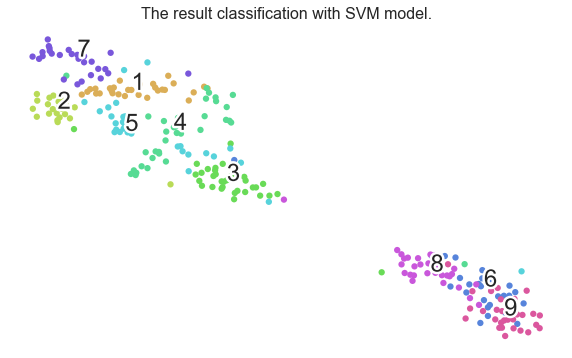

In [13]:
X_s = np.vstack([X_test[svc.predict(X_test)==i] for i in range(10)])
y_s = np.hstack([svc.predict(X_test)[svc.predict(X_test)==i] for i in range(10)])
digits_proj_s = TSNE(random_state=RS, perplexity=50).fit_transform(X_s)

plot_scatter(digits_proj_s, y_s)
plt.title('The result classification with SVM model.', size=16)
plt.show()

## <center>*3. RandomForest*

+ ### *3.1 Train the RandomForest model.*

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Complete the RandomForest using the train set.
rd1 = RandomForestClassifier()
rd1 = rd1.fit(X_train, y_train.ravel())
print('The score of test set is: ' + str(rd1.score(X_test, y_test.ravel())))

The score of test set is: 0.9056603773584906


+ ### *3.2 Evaluate the result.*

In [15]:
print(classification_report(y_test, rd1.predict(X_test)))

              precision    recall  f1-score   support

         1.0       0.88      0.91      0.89        32
         2.0       0.95      0.91      0.93        23
         3.0       0.89      0.94      0.91        33
         4.0       0.86      0.91      0.89        34
         5.0       0.92      0.82      0.87        28
         6.0       0.86      0.89      0.88        28
         7.0       0.92      0.92      0.92        25
         8.0       0.94      0.94      0.94        31
         9.0       0.97      0.90      0.93        31

    accuracy                           0.91       265
   macro avg       0.91      0.90      0.91       265
weighted avg       0.91      0.91      0.91       265



+ ### *3.3 Visualize the result.*

c:\users\warriors\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\warriors\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
posx and posy should be finite values
posx and posy should be finite values


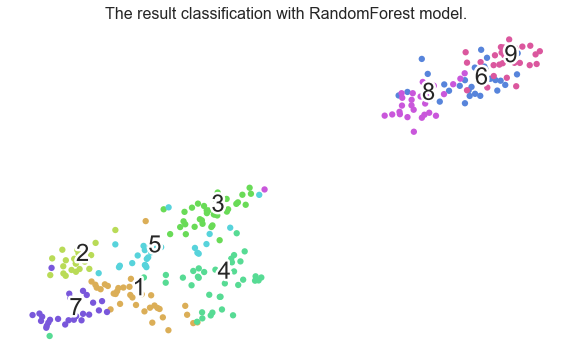

In [16]:
X_r = np.vstack([X_test[rd1.predict(X_test)==i] for i in range(10)])
y_r = np.hstack([rd1.predict(X_test)[rd1.predict(X_test)==i] for i in range(10)])
digits_proj_r = TSNE(random_state=RS, perplexity=50).fit_transform(X_r)

plot_scatter(digits_proj_r, y_r)
plt.title('The result classification with RandomForest model.', size=16)
plt.show()

***

## <center>*4. DecisionTree*

+ ### *4.1 Use sklearn.tree, train the model.*

In [17]:
from sklearn import tree

# Complete the DecisionTree.
dt1 = tree.DecisionTreeClassifier(criterion='entropy')
dt1 = dt1.fit(X_train, y_train)
print('The score of test set is: ' + str(dt1.score(X_test, y_test)))

The score of test set is: 0.7962264150943397


+ ### *4.2 Evaluate the model.*

In [18]:
print(classification_report(y_test, dt1.predict(X_test)))

              precision    recall  f1-score   support

         1.0       0.87      0.81      0.84        32
         2.0       0.74      0.87      0.80        23
         3.0       0.77      0.82      0.79        33
         4.0       0.64      0.74      0.68        34
         5.0       0.71      0.61      0.65        28
         6.0       0.74      0.82      0.78        28
         7.0       0.90      0.76      0.83        25
         8.0       0.96      0.87      0.92        31
         9.0       0.90      0.87      0.89        31

    accuracy                           0.80       265
   macro avg       0.80      0.80      0.80       265
weighted avg       0.80      0.80      0.80       265



+ ### *4.3 Visualize the result.*

c:\users\warriors\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\warriors\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
posx and posy should be finite values
posx and posy should be finite values


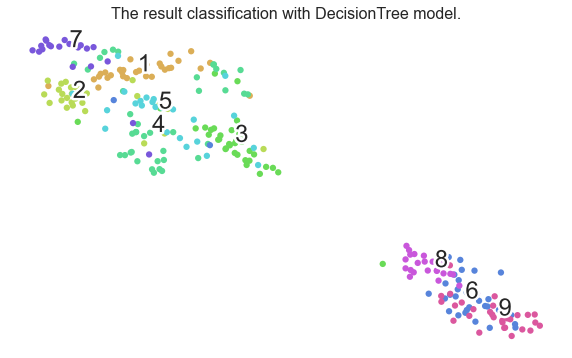

In [19]:
X_d = np.vstack([X_test[dt1.predict(X_test)==i] for i in range(10)])
y_d = np.hstack([dt1.predict(X_test)[dt1.predict(X_test)==i] for i in range(10)])
digits_proj_d = TSNE(random_state=RS, perplexity=50).fit_transform(X_d)

plot_scatter(digits_proj_d, y_d)
plt.title('The result classification with DecisionTree model.', size=16)
plt.show()

## <center>*5. Knn*

+ ### *5.1 Train a Knn model.*

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors

# Complete the Knn algorithm.
knn = KNeighborsClassifier(n_neighbors = 5, p = 2, metric= 'minkowski')
kn = knn.fit(X_train, y_train)
print('The score of test set is: ' + str(kn.score(X_test, y_test)))

<ipython-input-20-5408d99d8d45>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  kn = knn.fit(X_train, y_train)


The score of test set is: 0.9056603773584906


+ ### *5.2 Evaluate the Knn model.*

In [21]:
print(classification_report(y_test, kn.predict(X_test)))

              precision    recall  f1-score   support

         1.0       0.94      0.91      0.92        32
         2.0       0.96      0.96      0.96        23
         3.0       0.89      0.97      0.93        33
         4.0       0.88      0.82      0.85        34
         5.0       0.89      0.89      0.89        28
         6.0       0.81      0.93      0.87        28
         7.0       0.88      0.92      0.90        25
         8.0       0.97      0.90      0.93        31
         9.0       0.96      0.87      0.92        31

    accuracy                           0.91       265
   macro avg       0.91      0.91      0.91       265
weighted avg       0.91      0.91      0.91       265



+ ### *5.3 Visualize the result.*

c:\users\warriors\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\warriors\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
posx and posy should be finite values
posx and posy should be finite values


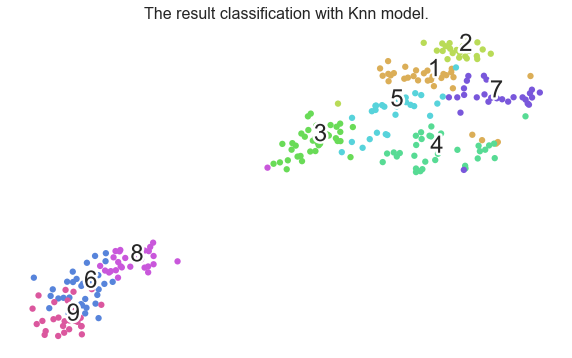

In [22]:
X_k = np.vstack([X_test[kn.predict(X_test)==i] for i in range(10)])
y_k = np.hstack([kn.predict(X_test)[kn.predict(X_test)==i] for i in range(10)])
digits_proj_k = TSNE(random_state=RS, perplexity=50).fit_transform(X_k)

plot_scatter(digits_proj_k, y_k)
plt.title('The result classification with Knn model.', size=16)
plt.show()